<a href="https://colab.research.google.com/github/Anderche/graph-theory-profitable-movie-ideas/blob/main/Graph_%26_AI_Anders_Kiss_Movies_to_Shortlist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neo4j
!pip install networkx
!pip install py2neo pandas matplotlib


     |████████████████████████████████| 89 kB 5.6 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.0-py3-none-any.whl size=114860 sha256=249c3e605e060d34865a28c006bc89f772d03daf91483c05f437614bf54fad96
  Stored in directory: /root/.cache/pip/wheels/b8/cb/e4/d34e10b40d33911c281a6e9aa038d54ca7435310529b3f6042
Successfully built neo4j
     |████████████████████████████████| 177 kB 7.8 MB/s 


In [ ]:
from neo4j import GraphDatabase
# import networkx as nx

import matplotlib.pyplot as plt
from py2neo import Graph
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

# sandbox
graph = Graph('bolt://3.95.161.151:7687', auth=("neo4j", "rake-platforms-allotment"))

# graph = Graph("bolt://18.234.208.38:7687", auth=("neo4j", "variations-correlations-rowers")) 
# graph = Graph("bolt://localhost", auth=("neo4j", "neo"))


In [ ]:
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Colab link:
https://colab.research.google.com/drive/1Nj4laWlHk3IG3x-2IfPeabhAnIFVJPJx?usp=sharing


# **BUSINESS UNDERSTANDING**

The following implementation could be useful for movie executives or management at Netflix, who are trying to decide the next project to fund. 

We want to investigate new movies to commission for next year, and as a result we will explore historical movies where the "revenue-to-budget" ratio is above 10. In other words, movies that were highly profitable.

This is a proxy for overall profit, since a ratio above "1" means that the movie was profitable.

After applying this filter, we can identify lists of both Actors and Directors and hire them for new movie production.

# **DATA UNDERSTANDING**

### **Review the NODE labels**

In [ ]:
graph.run("CALL db.schema.visualization()").data()

[{'nodes': [Node('_Bloom_Perspective_', constraints=["Constraint( id=61, name='constraint_2876b1c0', type='UNIQUENESS', schema=(:_Bloom_Perspective_ {id}), ownedIndex=60 )"], indexes=[], name='_Bloom_Perspective_'),
   Node('Movie', constraints=["Constraint( id=37, name='constraint_737d9c1d', type='UNIQUENESS', schema=(:Movie {tmdbId}), ownedIndex=34 )", "Constraint( id=3, name='constraint_3d5fcb7f', type='UNIQUENESS', schema=(:Movie {movieId}), ownedIndex=1 )"], indexes=['title', 'year', 'tagline', 'released', 'imdbRating', 'imdbId'], name='Movie'),
   Node('User', constraints=["Constraint( id=13, name='constraint_3b27b0', type='UNIQUENESS', schema=(:User {userId}), ownedIndex=11 )"], indexes=['name'], name='User'),
   Node('Actor', constraints=[], indexes=[], name='Actor'),
   Node('Director', constraints=[], indexes=[], name='Director'),
   Node('Genre', constraints=["Constraint( id=8, name='constraint_f8689281', type='UNIQUENESS', schema=(:Genre {name}), ownedIndex=6 )"], indexes=[

### **Explore NODE counts and RELATIONSHIP counts**

In [ ]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
6,_Bloom_Perspective_,1
1,Genre,20
2,User,671
4,Director,4091
0,Movie,9125
3,Actor,15443
5,Person,19047


In [ ]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
3,DIRECTED,10007
0,IN_GENRE,20340
2,ACTED_IN,35910
5,SIM_KNN,91250
1,RATED,100004
4,SIMILAR_KNN,547500


### **Visualize the NODE counts with matplotlib**

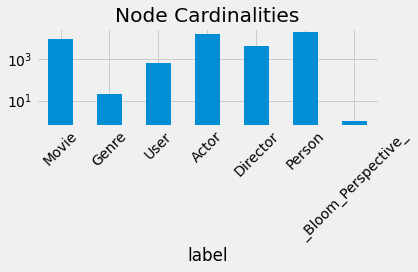

In [ ]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **DATA PREPARATION**

In [ ]:
# query = """MATCH (n) WHERE EXISTS(n.budget) RETURN DISTINCT "node" as movie_name, n.budget AS budget LIMIT 25 UNION ALL \
#           MATCH ()-[r]-() WHERE EXISTS(r.budget) RETURN DISTINCT "relationship" AS movie_name, r.budget AS budget LIMIT 25
#         """


# query = """MATCH (n) WHERE EXISTS(n.budget) RETURN DISTINCT "node" as movie_name, n.budget AS budget LIMIT 25 UNION ALL \
#           MATCH ()-[r]-() WHERE EXISTS(r.budget) RETURN DISTINCT "relationship" AS movie_name, r.budget AS budget LIMIT 25
#         """

query = """MATCH (n) WHERE EXISTS(n.ratio) RETURN DISTINCT "node" as entity, n.title AS title, n.ratio AS ratio ORDER BY ratio DESC, title DESC
"""

graph.run(query)

(No data)

In [ ]:
# Setting Profit property
query1 = """
MATCH (m:Movie)
SET m.profit = m.revenue - m.budget
RETURN m.profit
"""


In [ ]:

graph.run(query1)

m.profit
343554033
197797249
null


In [ ]:
#Set Profit ratio
query2="""
MATCH (m:Movie)
SET m.profitmargin = m.revenue/m.budget
RETURN m.profitmargin
"""

In [ ]:
graph.run(query2)

m.profitmargin
12
4
null


In [ ]:
 #PD Ratio & movie name of top 25 movies as per pb_ratio

query3 = """
MATCH (n) WHERE EXISTS(n.profit) RETURN DISTINCT "node" as entity, n.profit AS profit, n.title As title, n.pb_ratio AS pb_ratio ORDER BY pb_ratio DESC LIMIT 25 UNION ALL MATCH ()-[r]-() WHERE EXISTS(r.profit) RETURN DISTINCT "relationship" AS entity, r.profit AS profit, r.title As title, r.pb_ratio AS pb_ratio ORDER BY pb_ratio DESC LIMIT 25
"""



In [ ]:
graph.run(query3)

entity,profit,title,pb_ratio
node,4530818,Dangerous Beauty,40819
node,193340800,Paranormal Activity,12890
node,1161796,Tarnation,5330


In [ ]:
 #Actor, director and pd_ratio

query4 = """
MATCH (actor)-[:ACTED_IN]->(movie)<-[:DIRECTED]-(director)
RETURN movie.title, movie.pb_ratio, actor.name, director.name
"""

In [ ]:
graph.run(query4)

movie.title,movie.pb_ratio,actor.name,director.name
Toy Story,12,Jim Varney,John Lasseter
Toy Story,12,Tim Allen,John Lasseter
Toy Story,12,Tom Hanks,John Lasseter


# **MODELING**

## Model Movie Graph with 2x Graph Algorithms:

## 1. **K-Nearest Neighbor** (Similarity algorithm)

## 2. **Label Propagation** (Community Detection algorithm)


In [ ]:
#create k_near_neighbour
query5 = """
CALL gds.beta.knn.write({
  nodeProjection: 'Movie',
  relationshipProjection: {
    relType: {
      type: 'DIRECTED',
      orientation: 'NATURAL',
      properties: {}
    }
  },
  nodeWeightProperty: 'p_ratio',
  topK: 10,
  randomJoins: 10,
  sampleRate: 0.5,
  deltaThreshold: 0.001,
  nodeProperties: [
    'p_ratio'
  ],
  writeProperty: 'k-score-neighbour',
  writeRelationshipType: 'SIMILAR_KNN'
})
"""

In [ ]:
graph.run(query5)

createMillis,computeMillis,writeMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
65,589,2356,-1,9125,91250,"{p1: 0.5000038145808503, max: 1.000007629278116, p5: 1.000007629278116, p90: 1.000007629278116, p50: 1.000007629278116, p95: 1.000007629278116, p10: 1.000007629278116, p75: 1.000007629278116, p99: 1.000007629278116, p25: 1.000007629278116, p100: 1.000007629278116, min: 2.4622655473649502e-05, mean: 0.9911551912258761, stdDev: 0.08051821478326068}","{topK: 10, maxIterations: 100, writeConcurrency: 4, randomJoins: 10, perturbationRate: 0.0, sampleRate: 0.5, concurrency: 4, writeProperty: 'k-score-neighbour', writeRelationshipType: 'SIMILAR_KNN', nodeWeightProperty: 'p_ratio', nodeLabels: ['*'], sudo: false, relationshipTypes: ['*'], deltaThreshold: 0.001, username: null}"


In [ ]:
# Label Propagation 

query6 = """
CALL gds.labelPropagation.write({
  nodeProjection: 'Movie',
  relationshipProjection: {
    relType: {
      type: 'DIRECTED',
      orientation: 'UNDIRECTED',
      properties: {
        p_ratio: {
          property: 'p_ratio',
          defaultValue: 1
        }
      }
    }
  },
  relationshipWeightProperty: 'p_ratio',
  writeProperty: 'lpa'
})
"""

In [ ]:
graph.run(query6)

writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
22,9125,1,true,9125,"{p99: 1, min: 1, max: 1, mean: 1.0, p90: 1, p50: 1, p999: 1, p95: 1, p75: 1}",35,68,2,"{maxIterations: 10, writeConcurrency: 4, seedProperty: null, consecutiveIds: false, relationshipWeightProperty: 'p_ratio', concurrency: 4, writeProperty: 'lpa', nodeLabels: ['*'], sudo: false, nodeWeightProperty: null, relationshipTypes: ['*'], username: null}"


In [ ]:
# Stream KN 

query7 = """
CALL gds.beta.knn.stream(({
  nodeProjection: 'Movie',
  relationshipProjection: {
    relType: {
      type: 'DIRECTED',
      orientation: 'NATURAL',
      properties: {}
    }
  },
  nodeWeightProperty: 'p_ratio',
  topK: 10,
  randomJoins: 10,
  sampleRate: 0.5,
  deltaThreshold: 0.001,
  nodeProperties: [
    'p_ratio'
  ]
}))
YIELD node1, node2, similarity
WITH node1, collect({node: gds.util.asNode(node2), similarity: similarity}) AS to
RETURN gds.util.asNode(node1) AS from, to
LIMIT toInteger(42);
"""


In [ ]:
graph.run(query7)

from                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | to                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 